# 베드록 소개 - 스테이블 디퓨전을 활용한 이미지 생성

> *오류가 발생하면 이 노트북에서 사용하는 베드록 모델에 대한 허용 목록에 추가해야 할 수 있습니다*

> *이 노트북은 SageMaker Studio의 **`Data Science 3.0`** 커널에서 잘 작동해야 합니다*


--- 

이 데모 노트북에서는 이미지 생성 작업을 위해 베드록 파이썬 SDK를 활용하는 방법을 보여드리겠습니다. 스테이블 디퓨전 파운데이션 모델을 활용해 이미지를 생성하는 방법을 설명하겠습니다.

---

참고: 이 노트북은 Amazon SageMaker Studio의 Python 3 (Data Science 2.0) 커널에서 테스트되었습니다.

## 1. 설정 및 API 설명

---
노트북을 처음 실행하기 전에 이 셀을 실행하여 파이썬 boto3 SDK에 베드록 확장 기능을 추가하십시오.

---

In [2]:
%pip install -U boto3 botocore --quiet --force-reinstall

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 5.3.3 requires pyqt5<5.16, which is not installed.
spyder 5.3.3 requires pyqtwebengine<5.16, which is not installed.
distributed 2022.7.0 requires tornado<6.2,>=6.0.3, but you have tornado 6.3.3 which is incompatible.
jupyterlab 3.4.4 requires jupyter-server~=1.16, but you have jupyter-server 2.7.3 which is incompatible.
jupyterlab-server 2.10.3 requires jupyter-server~=1.4, but you have jupyter-server 2.7.3 which is incompatible.
panel 0.13.1 requires bokeh<2.5.0,>=2.4.0, but you have bokeh 3.3.0 which is incompatible.
sagemaker-datawrangler 0.4.3 requires sagemaker-data-insights==0.4.0, but you have sagemaker-data-insights 0.3.3 which is incompatible.
spyder 5.3.3 requires ipython<8.0.0,>=7.31.1, but you have ipython 8.16.1 which is incompatible.
spyder 5.3.3 requires pylint<3.0,>=2.5.0, but you have pyli

#### 이제 Boto3를 활용해 아마존 베드록 SDK에 대한 연결을 설정해 보겠습니다

In [3]:
#### Un comment the following lines to run from your local environment outside of the AWS account with Bedrock access

#import os
#os.environ['BEDROCK_ASSUME_ROLE'] = '<YOUR_VALUES>'
#os.environ['AWS_PROFILE'] = '<YOUR_VALUES>'

#### 이 노트북에서는 아마존 베드록의 invoke_model() 메서드를 사용할 것입니다. 이 메서드는 대부분의 이미지 생성 및 처리 작업에 주로 사용하게 될 것입니다.


##### 이 메서드를 사용하는 데 필요한 필수 매개변수는 modelId와 body입니다. modelId는 아마존 베드록 모델 ARN을 나타내고, body는 우리 작업을 위한 프롬프트입니다. body 프롬프트는 선택한 파운데이션 모델 제공업체에 따라 달라집니다. 이에 대해서는 아래에서 자세히 살펴보겠습니다

```
{
   modelId=model_id,
   contentType="application/json",
   accept="application/json",
   body=body
}

```

## 2. 텍스트로 이미지 생성

#### 이제 아마존 베드록의 스테이블 디퓨전 모델을 활용해 텍스트로 이미지를 생성해 보겠습니다

In [4]:
import boto3
import json 

bedrock = boto3.client(service_name="bedrock")
bedrock_runtime = boto3.client(service_name="bedrock-runtime")

In [5]:
prompt_data ="Golden retriever playing catch at a tropical, sunny beach with palm trees in the background."

In [6]:
negative_prompts = [
    "3d render", "smooth", "plastic", "blurry", "grainy", 
    "low-resolution", "anime", "deep-fried", "oversaturated", 
    "poorly rendered", "poor background details", "poorly drawn dog",
    "disfigured dog features"
    ]

In [7]:
style_preset = "photographic"

In [8]:
from botocore.config import Config
from botocore.exceptions import ClientError
import json
from PIL import Image
from io import BytesIO
import base64
from base64 import b64encode
from base64 import b64decode
import boto3


body = json.dumps(
    {"text_prompts":[{"text":prompt_data}],
     "style_preset": style_preset,
     "negative_prompts": negative_prompts
    }
) 

modelId = 'stability.stable-diffusion-xl'
accept = 'application/json'
contentType = 'application/json'

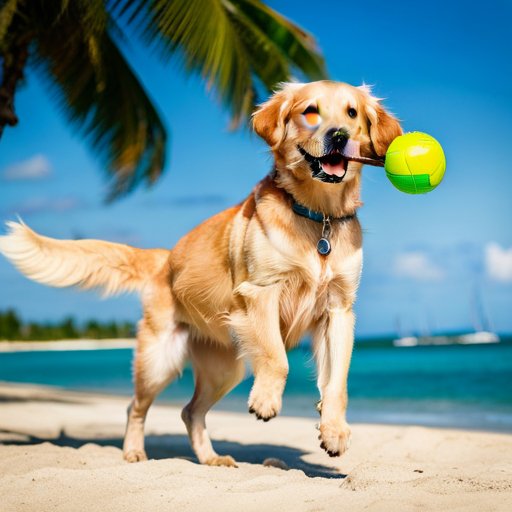

In [9]:
response = bedrock_runtime.invoke_model(body=body, modelId=modelId, accept=accept, contentType=contentType)
response = json.loads(response.get('body').read())
images = response.get('artifacts')

image = Image.open(BytesIO(b64decode(images[0].get('base64'))))
image.save("generated_image.png")
display(image)

## 3. 이미지로 이미지 생성

#### 스테이블 디퓨전을 활용하면 새로운 캐릭터를 추가하거나 배경을 수정하는 등 이미지로 흥미로운 작업을 할 수 있습니다. 한번 시도해 보겠습니다

In [10]:
prompt_data = "Change the dog to be a poodle"

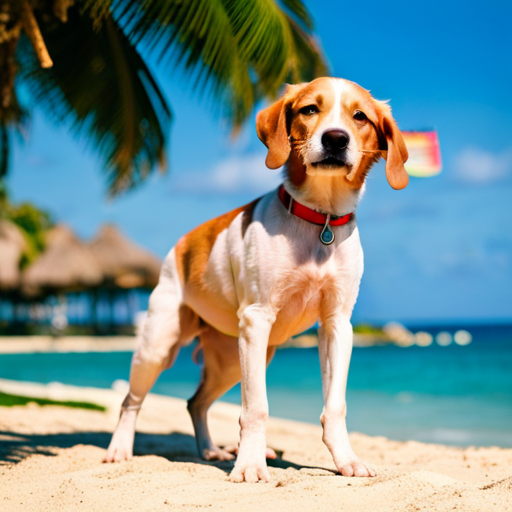

In [11]:
buffer = BytesIO()
img = Image.open("generated_image.png")
img.save(buffer, format="PNG")
img_bytes = buffer.getvalue()

body = json.dumps(
    {"text_prompts":[{"text": prompt_data }],
     "init_image": base64.b64encode(img_bytes).decode(),
     "style_preset": style_preset,
     "negative_prompts": negative_prompts
    }
)
modelId = 'stability.stable-diffusion-xl'

try: 
    response = bedrock_runtime.invoke_model(body=body, modelId=modelId, contentType="application/json", accept="image/png")
except ClientError as error:
    print(error.response)

if response['contentType'] == 'image/png':
    # Get the response body as bytes
    image_data = response['body'].read()
else:
    image_data = response['body']

image = Image.open(BytesIO(image_data))
file_name = 'converted.png'
#save file
image.save(file_name)
display(image)

## 골든 리트리버와 다른 이미지 생성하기

In [12]:
prompt_data = "Remove the ball from the image"

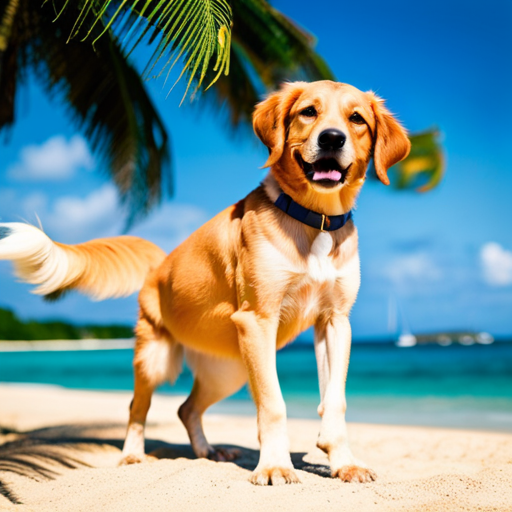

In [13]:
buffer = BytesIO()
img = Image.open("generated_image.png")
img.save(buffer, format="PNG")
img_bytes = buffer.getvalue()

body = json.dumps(
    {"text_prompts":[{"text": prompt_data }],
     "init_image": base64.b64encode(img_bytes).decode(),
     "style_preset": style_preset,
     "negative_prompts": negative_prompts
    }
)
modelId = 'stability.stable-diffusion-xl'

try: 
    response = bedrock_runtime.invoke_model(body=body, modelId=modelId, contentType="application/json", accept="image/png")
except ClientError as error:
    print(error.response)

if response['contentType'] == 'image/png':
    # Get the response body as bytes
    image_data = response['body'].read()
else:
    image_data = response['body']

image = Image.open(BytesIO(image_data))
file_name = 'converted-to-mountains.png'
#save file
image.save(file_name)
display(image)

In [14]:
prompt_data = "Upscale to 8K resolution"

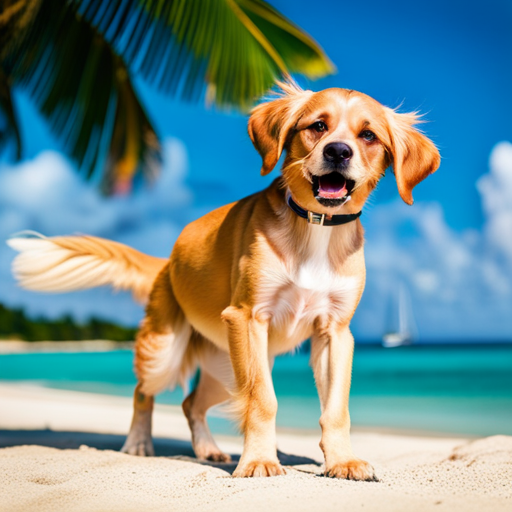

In [15]:
buffer = BytesIO()
img = Image.open("generated_image.png")
img.save(buffer, format="PNG")
img_bytes = buffer.getvalue()

body = json.dumps(
    {"text_prompts":[{"text": prompt_data }],
     "init_image": base64.b64encode(img_bytes).decode(),
     "style_preset": style_preset,
     "negative_prompts": negative_prompts
    }
)
modelId = 'stability.stable-diffusion-xl'

try: 
    response = bedrock_runtime.invoke_model(body=body, modelId=modelId, contentType="application/json", accept="image/png")
except ClientError as error:
    print(error.response)

if response['contentType'] == 'image/png':
    # Get the response body as bytes
    image_data = response['body'].read()
else:
    image_data = response['body']

image = Image.open(BytesIO(image_data))
file_name = 'upscaled-to-8k.png'
#save file
image.save(file_name)
display(image)